Analysis of Consumer Data

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import re
import glob
import math
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, LongType, IntegerType
from datetime import datetime, timedelta

In [2]:
spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .config("spark.executor.memory", "15g") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .appName('analysis') \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
24/09/19 14:19:51 WARN Utils: Your hostname, DESKTOP-F216TKE resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/09/19 14:19:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/19 14:19:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
consumer_fraud = spark.read.parquet(".././data/curated/consumer_fraud")
consumer_fraud.show()

+-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|   6228|    2021-12-19| 97.6298077657765|
|  21419|    2021-12-10|99.24738020302328|
|   5606|    2021-10-17|84.05825045251777|
|   3101|    2021-04-17|91.42192091901347|
|  22239|    2021-10-19|94.70342477508035|
|  16556|    2022-02-20|89.65663294494827|
|  10278|    2021-09-28|83.59136689427714|
|  15790|    2021-12-30|71.77065889280253|
|   5233|    2021-08-29|85.87123303878818|
|    230|    2021-08-28|86.28328808934151|
|  13601|    2021-12-26|83.13696487489679|
|   6383|    2021-09-15| 66.2676451623754|
|   3513|    2022-02-27|75.16981192247916|
|  18658|    2021-10-19|82.98609082999361|
|   5965|    2021-11-14|69.37164467869053|
|  18714|    2021-11-14|83.78813794627237|
|  22957|    2022-02-12|82.79065699075498|
|  20118|    2021-09-05|80.34030486265003|
|   6436|    2021-12-24|84.81618344606828|
|  17900|    2022-02-25|92.73262811161372|
+-------+--

In [3]:
consumer_details = spark.read.parquet(".././data/curated/consumer_details")
transactions = spark.read.parquet(".././data/curated/total_transactions")
merchant_fraud = spark.read.parquet(".././data/curated/merchant_fraud")
tbl_consumer = spark.read.parquet(".././data/curated/tbl_consumer")
tbl_merchant = spark.read.parquet(".././data/curated/tbl_merchants")

In [5]:
consumer_details.show()

+-------+-----------+
|user_id|consumer_id|
+-------+-----------+
|      1|    1195503|
|      2|     179208|
|      3|    1194530|
|      4|     154128|
|      5|     712975|
|      6|     407340|
|      7|     511685|
|      8|     448088|
|      9|     650435|
|     10|    1058499|
|     11|     428325|
|     12|    1494640|
|     13|    1146717|
|     14|    1343547|
|     15|    1463076|
|     16|    1356405|
|     17|    1331093|
|     18|      80965|
|     19|    1226530|
|     20|    1390367|
+-------+-----------+
only showing top 20 rows



In [6]:
transactions.show()

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  11138| 63290521567|41.239626303220014|09f6132a-a6a8-47a...|    2022-08-25|
|  22285| 63465140133| 8.815286645396842|f4fc1a3b-a5b1-4d7...|    2022-08-25|
|  11139| 21359184622| 66.46301590693417|b1a52524-b6e6-42a...|    2022-08-25|
|  22285| 75034515922|19.654995598411727|ba240514-5dea-405...|    2022-08-25|
|  11140| 96334476428| 6.383881161736656|3f1c61aa-6b5b-4c8...|    2022-08-25|
|  22285| 96442520325| 91.14307120608396|89e25ac5-7775-4be...|    2022-08-25|
|  11140| 74753274268| 1532.603740282265|9764b14c-82ba-498...|    2022-08-25|
|  22288| 89107518982| 89.41184219239359|b95d447c-a089-4a5...|    2022-08-25|
|  11140| 28896046710|   371.95178106226|dd5d2e91-c03b-4f0...|    2022-08-25|
|  22289| 86578477987| 29.86919166344463|91317698-0a33-468...|  

In [7]:
merchant_fraud.show()

+------------+--------------+------------------+
|merchant_abn|order_datetime| fraud_probability|
+------------+--------------+------------------+
| 19492220327|    2021-11-28|44.403658647495355|
| 31334588839|    2021-10-02| 42.75530083865367|
| 19492220327|    2021-12-22|38.867790051131095|
| 90918180829|    2021-09-02| 43.32551731714902|
| 31334588839|    2021-12-26| 38.36165958070444|
| 31334588839|    2021-11-26| 36.20971272078342|
| 19492220327|    2021-12-18|33.819672154331755|
| 31334588839|    2021-11-29|35.386213297375505|
| 19492220327|    2021-11-18|32.193139919494016|
| 93260930990|    2021-11-30| 37.87197154172081|
| 90918180829|    2021-09-16| 36.62001350882694|
| 83199298021|    2022-02-27|26.025158824861773|
| 83199298021|    2022-02-17| 25.77998392496447|
| 97217894162|    2022-01-21| 34.94582650821017|
| 43083074133|    2021-12-18| 48.66890735193894|
| 19492220327|    2021-10-18|30.935658544112286|
| 31334588839|    2021-09-23|  32.3890854385705|
| 90918180829|    20

In [8]:
tbl_consumer.show()

+--------------------+-----+--------+-----------+-----------+
|       consumer_name|state|postcode|     gender|consumer_id|
+--------------------+-----+--------+-----------+-----------+
|     Courtney Mendez|  QLD|    9013|     Female|     680810|
|          John Garza|   SA|    5301|       Male|     531402|
|          Adam Bowen|   SA|    5201|       Male|    1440589|
|     Jeffrey Harding|  VIC|    8205|       Male|     699376|
|Mr. Antonio Peterson|  QLD|    4075|       Male|     829756|
|       Joshua Butler|   SA|    5352|       Male|    1306078|
|           Paul Bond|  VIC|    3612|Undisclosed|     240015|
|         Jason Terry|   WA|    6919|       Male|     173131|
|          John Clark|  VIC|    3747|       Male|      18096|
|         Sandra Hill|  VIC|    3889|     Female|     967190|
|     Julie Rodriguez|   SA|    5095|     Female|     772666|
|       Allison Baker|   SA|    5131|     Female|    1065543|
|     Taylor Saunders|  NSW|    2206|       Male|    1237914|
|       

In [9]:
tbl_merchant.show()

+--------------------+--------------------+------------+--------------------+-----+-----+
|       merchant_name|                tags|merchant_abn|               tags1|tags2|tags3|
+--------------------+--------------------+------------+--------------------+-----+-----+
|       Felis Limited|[[furniture, home...| 10023283211|[furniture, home ...|    e| 0.18|
|Arcu Ac Orci Corp...|[[cable, satellit...| 10142254217|[cable, satellite...|    b| 4.22|
|    Nunc Sed Company|[[jewelry, watch,...| 10165489824|[jewelry, watch, ...|    b|  4.4|
|Ultricies Digniss...|[[watch, clock, a...| 10187291046|[watch, clock, an...|    b| 3.29|
| Enim Condimentum PC|[[music shops - m...| 10192359162|[music shops - mu...|    a| 6.33|
|       Fusce Company|[[gift, card, nov...| 10206519221|[gift, card, nove...|    a| 6.34|
|Aliquam Enim Inco...|[[computers, comp...| 10255988167|[computers, compu...|    b| 4.32|
|    Ipsum Primis Ltd|[[watch, clock, a...| 10264435225|[watch, clock, an...|    c| 2.39|
|Pede Ultr

In [17]:
merchant_fraud = merchant_fraud.withColumnRenamed('fraud_probability', 'merchant_fraud')

In [18]:
full_transactions = transactions.join(consumer_details, on="user_id",how="left") \
                   .join(tbl_consumer, on="consumer_id",how="left") \
                   .join(consumer_fraud, on=["user_id", "order_datetime"],how="left") \
                   .join(tbl_merchant, on="merchant_abn",how="left") \
                   .join(merchant_fraud, on=["order_datetime", "merchant_abn"], how="left")

In [19]:
full_transactions.show()

+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+--------+------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------+
|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|     consumer_name|state|postcode|gender|fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud|
+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+--------+------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------+
|    2022-08-25| 63290521567|  11138|     401483|41.239626303220014|09f6132a-a6a8-47a...|   Veronica Nelson|   WA|    6519|Female|             NULL|Vehicula Pellente...|[[artist supply a...|[artist supply an...|    a| 6.48|          NULL|
|    2022-08-25| 63465140133|  22285|     41

In [20]:
full_transactions.write.mode('overwrite').parquet('.././data/curated/full_transactions')

In [10]:
fraud = consumer_fraud.select(F.col('fraud_probability')).toPandas()['fraud_probability']
fraud = list(fraud)

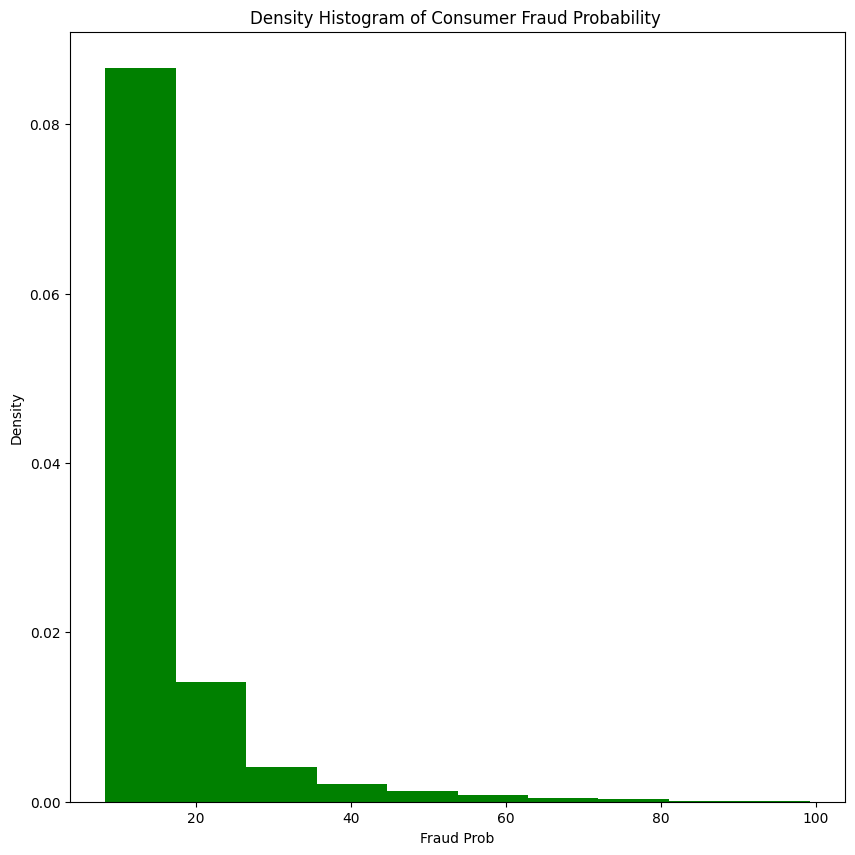

In [13]:
plt.figure(figsize=(10,10))
plt.hist(fraud, density = True, color = "green")
plt.title('Density Histogram of Consumer Fraud Probability ')
plt.xlabel('Fraud Prob')
plt.ylabel('Density')
plt.savefig('.././plots/consumerdensityfraud')

In [11]:
logfraud = [math.log(x) for x in fraud]

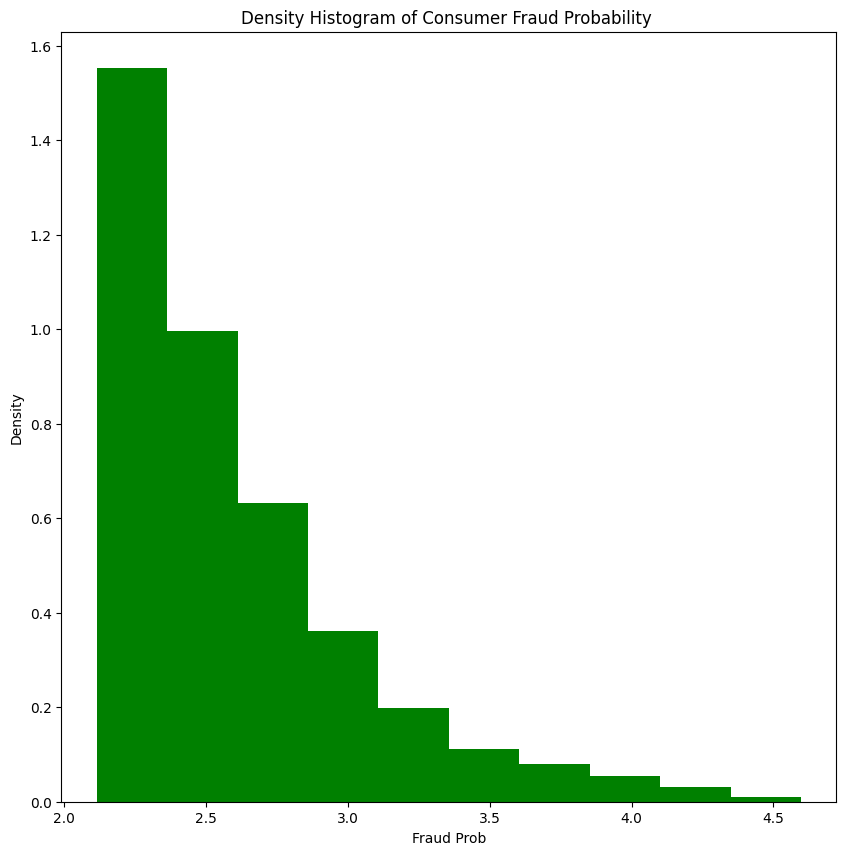

In [12]:
plt.figure(figsize=(10,10))
plt.hist(logfraud, density = True, color = "green")
plt.title('Density Histogram of Consumer Fraud Probability ')
plt.xlabel('Fraud Prob')
plt.ylabel('Density')
plt.show()

In [14]:
dates = consumer_fraud.select(F.col('order_datetime')).toPandas()['order_datetime']
dates = list(dates)

In [4]:
tbl_merchant.count()

4026